In [2]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle as pkl
import cv2
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
import math
import colorsys

In [ ]:
def resize_to_3d(image: np.array):
    img = np.reshape(image, (32, 32, 1))
    img = np.repeat(img, 3, axis=3)
    return img


In [62]:
def kmeans( image, n ):                     # Uses k-Means to quantize an image into n colors.
    image = cv2.cvtColor( image, cv2.COLOR_BGR2LAB )# The LAB color space is especially useful for this type of system, as it's similar to how a human eye works
    w, h, _ = image.shape                           # Gets the shape of the image for the next step
    image = image.reshape( ( image.shape[ 0 ] * image.shape[ 1 ], 3 ) ) #k-Means required an image to be one pixel tall for some reason
    clt = MiniBatchKMeans( n_clusters = n )         # Creates a new kMeans system. Cluster count tells how many regions of best fit should be made.
    labels = clt.fit_predict( image )               # This takes a aet of inputted colors and tries to find clusters of data. Similar to how one might move a '3d cursor' to the center of data on -a 3d mqp
    quant = clt.cluster_centers_.astype( "uint8" )[ labels ]    #Replaces every pixel with the closewt color k-Means found
    quant = quant.reshape( ( h, w, 3 ) )            # Rescales the quantized image back into its original shape. Simply imagine the pixels line wrqpping similar to a wore processor
    quant = cv2.cvtColor( quant, cv2.COLOR_LAB2BGR )# Reverts the color as well
    #for i in labels: print(labels)
    return quant, labels


def preprocess(x_train, x_test, y_train, y_test, num_classes, regression=False):
    if type(x_train) != np.ndarray:
        x_train = x_train.to_numpy().astype('float32')
        x_test = x_test.to_numpy().astype('float32')
        y_train = y_train.to_numpy().astype('float32')
        y_test = y_test.to_numpy().astype('float32')
    if regression == False:
        y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

    x_train = np.reshape(x_train, (-1, int(math.sqrt(x_train.shape[1])), int(math.sqrt(x_train.shape[1]))))
    x_test = np.reshape(x_test, (-1, int(math.sqrt(x_test.shape[1])), int(math.sqrt(x_test.shape[1]))))

    x_train_ = np.zeros((x_train.shape[0], 32, 32))
    x_test_ = np.zeros((x_test.shape[0], 32, 32))

    for i in range(x_train.shape[0]):
        x_train_[i] = cv2.resize(x_train[i], (32, 32))

    for i in range(x_test.shape[0]):
        x_test_[i] = cv2.resize(x_test[i], (32, 32))

    x_train = x_train_
    x_test = x_test_

    x_train = np.reshape(x_train, (-1, 32, 32, 1))
    x_test = np.reshape(x_test, (-1, 32, 32, 1))

    x_train = np.repeat(x_train, 3, axis=3)
    x_test = np.repeat(x_test, 3, axis=3)
    return x_train, x_test, y_train, y_test

def avg_distance_from_center(image: np.array):
    subs = (np.argwhere(image>0) - np.array([5/2, 5/2]))
    out = np.sqrt(np.einsum('ij,ij->i',subs,subs)).mean()
    return out

def view(image):
    plt.imshow(image)
    plt.show()



In [41]:
df = pd.DataFrame(columns=["image", "shape", "letter", "rotation"])
df["image"] = df["image"].astype(object)

shape_labels = ["circle", "semicircle", "quartercircle", "triangle",
          "square", "rectangle", "trapezoid", "pentagon", "hexagon",
          "heptagon", "octagon", "star", "cross"]

with open('./data/vals.txt') as f:
    for line in f.readlines():
        path, label = line.split(' ')
        label = [int(i) for i in label.split(",")]
        x1, y1, x2, y2, zero = label
        img = cv2.imread(f"./data/{path}")
        img = img[y1:y2, x1:x2]
        size=28  # 28x28 image
        #dx = size-(x2-x1)
        #dy = size-(y2-y1)
        #if dx % 2 == 1:  # if odd, do put +1 more padding on one side
        #    fx1 = (dx-1)//2  # x dim first padding
        #    fx2 = fx1+1  # x dim last padding
#
        #    fy1 = (dy-1)//2  # y dim first padding
        #    fy2 = fy1+1  # y dim last padding
        #else:
        #    fx1, fx2 = dx//2, dx//2
        #    fy1, fy2 = dy//2, dy//2
#
        #padded_img = np.pad(img, ((fy1, fy2), (fx1, fx2), (0, 0)))
        padded_img = cv2.resize(padded_img, (32, 32))
        nothing, shape, letter, rotation = path.split("_")
        rotation = rotation.split(".")[0]
        data = {
            "image": [padded_img],
            "shape": [shape],
            "letter": [letter],
            "rotation": [rotation]
        }
        df2 = pd.DataFrame(data)
        df = df.append(df2)

In [ ]:
#Letter Classifier
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

images = df["image"].to_numpy()
images = np.array(images)
images = np.vstack(images)
images = np.reshape(images, (-1, 75, 75, 3))

labels = np.asarray(df["letter"])
encode = np.vectorize(alphabet.index)
labels = encode(labels)
labels = keras.utils.to_categorical(labels, num_classes=26)

images_ = np.zeros((images.shape[0], 32, 32))

for i in range(images.shape[0]):
    images_[i] = cv2.resize(images[i], (32, 32))

images = images_

#data_augmentation = keras.Sequential(
#    [
#        keras.layers.RandomFlip(),
#        keras.layers.RandomRotation(0.1),
#        keras.layers.RandomZoom(0.1),
#    ]
#)
#
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_dataset = train_dataset.batch(16).map(lambda x, y: (data_augmentation(x), y))
#
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#train_dataset = test_dataset.batch(16)
model = keras.models.load_model('./models/letter_classifier')
y = model.predict(images[0])
print(y)
#model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
             # loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

#callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=.5, patience=3, restore_best_weights=True)

#model.fit(x=x_train, y=y_train, batch_size=16, epochs=100, validation_data=(x_test, y_test), shuffle=True)#, callbacks=[callback])


In [36]:
df_letter = pd.read_csv("letter_data.csv", names=[str(i) for i in range(785)])

In [7]:
class ConvNetLetter(keras.Model):
    def __init__(self):
        super(ConvNetLetter, self).__init__()
        self.norm = tf.keras.layers.Normalization(axis=None)
        self.resnet = keras.applications.ResNet50V2(weights='imagenet', include_top=False,
                                                    input_shape=(32, 32, 3))
        for layer in self.resnet.layers:
            layer.trainable = False
        self.model = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(26, activation='softmax')
        ])

    def call(self, inputs):
        x = self.norm(inputs)
        x = self.resnet(x)
        return self.model(x)


In [8]:

x_train, x_test, y_train, y_test = train_test_split(df_letter.drop(columns="0"), df_letter["0"], test_size=0.16,
                                                    random_state=19, stratify=df_letter["0"])

x_train, x_test, y_train, y_test = preprocess(x_train, x_test, y_train, y_test, 26)

print(x_train.shape)
print(y_train.shape)
model = ConvNetLetter()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=.5, patience=5, restore_best_weights=True)

model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])
model.save("./models/letter_classifier")

(312858, 32, 32, 3)
(312858, 26)
Epoch 1/100
4889/4889 [==============================] - 76s 15ms/step - loss: 7.3532 - accuracy: 0.7508 - val_loss: 10.2017 - val_accuracy: 0.7545
Epoch 2/100
4889/4889 [==============================] - 72s 15ms/step - loss: 5.0534 - accuracy: 0.8376 - val_loss: 5.8809 - val_accuracy: 0.8091
Epoch 3/100
4889/4889 [==============================] - 72s 15ms/step - loss: 4.7527 - accuracy: 0.8559 - val_loss: 6.1472 - val_accuracy: 0.8218
Epoch 4/100
4889/4889 [==============================] - 71s 14ms/step - loss: 4.5664 - accuracy: 0.8653 - val_loss: 4.2156 - val_accuracy: 0.8866
Epoch 5/100
4889/4889 [==============================] - 71s 14ms/step - loss: 4.4711 - accuracy: 0.8719 - val_loss: 12.0749 - val_accuracy: 0.7271
Epoch 6/100
4889/4889 [==============================] - 70s 14ms/step - loss: 4.4212 - accuracy: 0.8775 - val_loss: 6.8827 - val_accuracy: 0.8127
INFO:tensorflow:Assets written to: ./models/letter_classifier\assets


(9604,)
<class 'pandas.core.series.Series'>


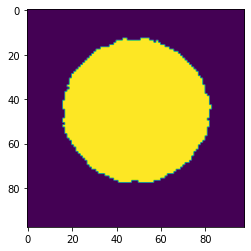

NameError: name 'wefwefwe' is not defined

In [80]:
df_shape = pd.read_csv("shape_data2.csv", names=[str(i) for i in range(98*98 + 1)])

In [ ]:
class ConvNetShapeLetter(keras.Model):
    def __init__(self):
        super(ConvNetShapeLetter, self).__init__()
        self.norm = tf.keras.layers.Normalization(axis=None)
        self.resnet = keras.applications.ResNet50V2(weights='imagenet', include_top=False,
                                                    input_shape=(32, 32, 3))
        for layer in self.resnet.layers:
            layer.trainable = False
        self.model = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(13, activation='softmax')
        ])

    def call(self, inputs):
        x = self.norm(inputs)
        x = self.resnet(x)
        return self.model(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10920, 32, 32, 3)
(10920, 13)


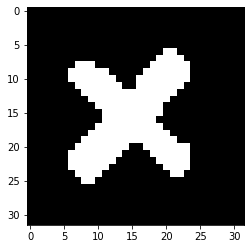

Epoch 1/100
171/171 [==============================] - 6s 24ms/step - loss: 25.9518 - accuracy: 0.4929 - val_loss: 11.1240 - val_accuracy: 0.6567
Epoch 2/100
171/171 [==============================] - 3s 16ms/step - loss: 10.0631 - accuracy: 0.7318 - val_loss: 12.6936 - val_accuracy: 0.7625
Epoch 3/100
171/171 [==============================] - 3s 15ms/step - loss: 6.8766 - accuracy: 0.8056 - val_loss: 3.7638 - val_accuracy: 0.8889
Epoch 4/100
171/171 [==============================] - 3s 17ms/step - loss: 5.6883 - accuracy: 0.8496 - val_loss: 12.6956 - val_accuracy: 0.7716
Epoch 5/100
171/171 [==============================] - 3s 16ms/step - loss: 4.7114 - accuracy: 0.8730 - val_loss: 2.2263 - val_accuracy: 0.8899
Epoch 6/100
171/171 [==============================] - 3s 17ms/step - loss: 3.7445 - accuracy: 0.8983 - val_loss: 13.0641 - val_accuracy: 0.8538
INFO:tensorflow:Assets written to: ./models/classify_shape\assets


In [81]:
x_train, x_test, y_train, y_test = train_test_split(df_shape.drop(columns="0"), df_shape["0"], test_size=0.16,
                                                    random_state=19, stratify=df_shape["0"])

x_train, x_test, y_train, y_test = preprocess(x_train, x_test, y_train, y_test, 13)
print(x_train.shape)
print(y_train.shape)

model = ConvNetShapeLetter()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=.5, patience=5, restore_best_weights=True)

model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])
model.save("./models/classify_shape")

In [83]:
class ConvNetClassify(keras.Model):
    def __init__(self):
        super(ConvNetClassify, self).__init__()
        self.norm = tf.keras.layers.Normalization(axis=None)
        self.resnet = keras.applications.ResNet50V2(weights='imagenet', include_top=False,
                                                    input_shape=(32, 32, 3))
        for layer in self.resnet.layers:
            layer.trainable = False
        self.model = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(2, activation='softmax')
        ])

    def call(self, inputs):
        x = self.norm(inputs)
        x = self.resnet(x)
        return self.model(x)

In [86]:
df_shape = pd.read_csv("shape_data3.csv", names=[str(i) for i in range(785)])
df_letter = pd.read_csv("letter_data.csv", names=[str(i) for i in range(785)])

print("DONE")
df_letter["0"] = 0  # 0 is letter, 1 is shape
df_shape["0"] = 1

df_classify = pd.concat([df_shape, df_letter])

x_train, x_test, y_train, y_test = train_test_split(df_classify.drop(columns="0"), df_classify["0"], test_size=0.16,
                                                    random_state=19, stratify=df_classify["0"])

x_train, x_test, y_train, y_test = preprocess(x_train, x_test, y_train, y_test, 2)

model = ConvNetClassify()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=.5, patience=5, restore_best_weights=True)

model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])
model.save("./models/classify") # one hot encoding, [1, 0] is letter, [0, 1] is shape

DONE
Epoch 1/100
4992/4992 [==============================] - 92s 18ms/step - loss: 0.0104 - accuracy: 0.9996 - val_loss: 4.0890e-05 - val_accuracy: 1.0000
Epoch 2/100
4992/4992 [==============================] - 92s 18ms/step - loss: 8.0954e-04 - accuracy: 1.0000 - val_loss: 8.1071e-09 - val_accuracy: 1.0000
Epoch 3/100
4992/4992 [==============================] - 88s 18ms/step - loss: 1.6787e-04 - accuracy: 1.0000 - val_loss: 9.2125e-04 - val_accuracy: 0.9999
Epoch 4/100
4992/4992 [==============================] - 91s 18ms/step - loss: 2.2252e-04 - accuracy: 1.0000 - val_loss: 1.7128e-08 - val_accuracy: 1.0000
Epoch 5/100
4992/4992 [==============================] - 91s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.6141e-09 - val_accuracy: 1.0000
Epoch 6/100
4992/4992 [==============================] - 91s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.0760e-08 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: ./models/classify\assets


In [ ]:
class ConvNetRotation(keras.Model):
    def __init__(self):
        super(ConvNetRotation, self).__init__()
        self.norm = tf.keras.layers.Normalization(axis=None)
        self.resnet = keras.applications.ResNet50V2(weights='imagenet', include_top=False,
                                                    input_shape=(32, 32, 3))
        for layer in self.resnet.layers:
            layer.trainable = False
        self.model = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(360, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='tanh')
        ])

    def call(self, inputs):
        x = self.norm(inputs)
        x = self.resnet(x)
        return self.model(x)

In [ ]:
def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)

def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    print(y_true, y_pred)
    diff = angle_difference(keras.backend.argmax(y_true), keras.backend.argmax(y_pred))
    return keras.backend.mean(keras.backend.cast(keras.backend.abs(diff), keras.backend.floatx()))


def angle_error_regression(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a float number between 0 and 1.
    """
    return keras.backend.mean(angle_difference(y_true * 360, y_pred * 360))

df_rotation = pd.read_csv("rotation.csv", names=[str(i) for i in range(785)])

x_train, x_test, y_train, y_test = train_test_split(df_rotation.drop(columns="0"), df_rotation["0"], test_size=0.16,
                                                    random_state=19, stratify=df_rotation["0"])

x_train, x_test, y_train, y_test = preprocess(x_train, x_test, y_train, y_test, 360, regression=True)

model = ConvNetRotation()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss="mse", metrics=[angle_error])

callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=.5, patience=5, restore_best_weights=True)

model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])
model.save("./models/rotation")

In [3]:
def kmeans( image, n ):                     # Uses k-Means to quantize an image into n colors.
    image = cv2.cvtColor( image, cv2.COLOR_BGR2LAB )# The LAB color space is especially useful for this type of system, as it's similar to how a human eye works
    w, h, _ = image.shape                           # Gets the shape of the image for the next step
    image = image.reshape( ( image.shape[ 0 ] * image.shape[ 1 ], 3 ) ) #k-Means required an image to be one pixel tall for some reason
    clt = MiniBatchKMeans( n_clusters = n )         # Creates a new kMeans system. Cluster count tells how many regions of best fit should be made.
    labels = clt.fit_predict( image )               # This takes a aet of inputted colors and tries to find clusters of data. Similar to how one might move a '3d cursor' to the center of data on -a 3d mqp
    quant = clt.cluster_centers_.astype( "uint8" )[ labels ]    #Replaces every pixel with the closewt color k-Means found
    quant = quant.reshape( ( h, w, 3 ) )            # Rescales the quantized image back into its original shape. Simply imagine the pixels line wrqpping similar to a wore processor
    quant = cv2.cvtColor( quant, cv2.COLOR_LAB2BGR )# Reverts the color as well
    #for i in labels: print(labels)
    return quant, labels

def mask(img, color):
    image = img.copy()
    for x in range(image.shape[0]):
        for y in range(image.shape[0]):
            if not np.array_equal(image[x, y], color):
                image[x, y] = np.array([0, 0, 0])
            else:
                image[x, y] = np.array([255, 255, 255])
    return image


def get_shape_and_image_picture(img: np.array):
    new_img = np.reshape(img, (-1, 3))
    colors = np.unique(new_img, axis=0)
    l = []
    for color in colors:
        image = mask(img, color)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        d = avg_distance_from_center(image.copy())
        l.append([image, d])
    l = sorted(l, key=lambda tup: tup[1])
    return l[0][0], l[1][0]  # letter image, shape image

def avg_distance_from_center(image: np.array):
    subs = (np.argwhere(image>0) - np.array([5/2, 5/2]))
    out = np.sqrt(np.einsum('ij,ij->i',subs,subs)).mean()
    return out

In [ ]:
def main(img: np.array):
    letter_model = keras.models.load_model("models/letter_classifier")
    shape_model = keras.models.load_model("models/classify_shape")
    shape_labels = ["circle", "semicircle", "quartercircle", "triangle",
              "square", "rectangle", "trapezoid", "pentagon", "hexagon",
              "heptagon", "octagon", "star", "cross"]
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    img = cv2.resize(img, (28,28))
    img, labels = kmeans(img, 4)
    letter_image, shape_image = get_shape_and_image_picture(img)
    shape_image = cv2.bitwise_or(letter_image, shape_image)
    letter_image = cv2.cvtColor(letter_image, cv2.COLOR_GRAY2RGB)
    shape_image = cv2.cvtColor(shape_image, cv2.COLOR_GRAY2RGB)

    letter_image = np.reshape(letter_image, (1, 32, 32, 3)).astype('float32')
    shape_image = np.reshape(shape_image, (1, 32, 32, 3)).astype('float32')

    letter_matrix = letter_model.predict(letter_image)
    shape_matrix = shape_model.predict(shape_image)
    return alphabet[np.argmax(letter_matrix)], shape_labels[np.argmax(shape_matrix)]  # letter, shape prediction

In [8]:
letter_model = keras.models.load_model("models/letter_classifier")
shape_model = keras.models.load_model("models/classify_shape")
shape_labels = ["circle", "semicircle", "quartercircle", "triangle",
          "square", "rectangle", "trapezoid", "pentagon", "hexagon",
          "heptagon", "octagon", "star", "cross"]
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
letter_correct = 0
shape_correct = 0
both_correct = 0
count = 0
with open('./data/vals.txt') as f:
    for line in f.readlines():
        if count >= 100:
            break
        path, label = line.split(' ')
        label = [int(i) for i in label.split(",")]
        x1, y1, x2, y2, zero = label
        img = cv2.imread(f"./data/{path}")
        img = img[y1:y2, x1:x2]
        nothing, shape, letter, rotation = path.split("_")
        rotation = rotation.split(".")[0]


        size=28  # 28x28 image
        #plt.imshow(img)
        #plt.show()
        img = img.copy()
        img = cv2.resize(img, (28,28))

        img, labels = kmeans(img, 4)
        letter_image, shape_image = get_shape_and_image_picture(img)
        shape_image = cv2.bitwise_or(letter_image, shape_image)
        #letter_image = cv2.resize(letter_image, (300,300))
        #shape_image = cv2.resize(shape_image, (300, 300))
        #cv2.imshow(letter, letter_image)
        #cv2.imshow(shape, shape_image)
        #cv2.waitKey(0)
        letter_image = cv2.cvtColor(letter_image, cv2.COLOR_GRAY2RGB)
        shape_image = cv2.cvtColor(shape_image, cv2.COLOR_GRAY2RGB)

        letter_image = np.reshape(letter_image, (1, 32, 32, 3)).astype('float32')
        shape_image = np.reshape(shape_image, (1, 32, 32, 3)).astype('float32')

        letter_matrix = letter_model.predict(letter_image)
        shape_matrix = shape_model.predict(shape_image)

        if alphabet[np.argmax(letter_matrix)] == letter:
            letter_correct += 1
        if shape_labels[np.argmax(shape_matrix)] == shape:
            shape_correct += 1
        if alphabet[np.argmax(letter_matrix)] == letter and shape_labels[np.argmax(shape_matrix)] == shape:
            both_correct += 1
print(letter_correct)
print(shape_correct)
print(count)








KeyboardInterrupt: 